In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline 

# Part 3: Modeling

## Predicting Song Likeability Using Spotify Audio Features

Welcome!  This notebook is the third notebook in my supervised learning capstone.  In Part I, I used a lightweight python library called Spotipy to access the Spotify Web API.  In Part II, I processed the data to get it into a ready to use format.  Here, we'll build up some models.

__OVERVIEW__

So, what exactly did I get from Spotify?  Audio features, lots of audio features.  

Motivation for this project came from a Kaggle challenge I came across.  If you're interested in the details, you can read about it here:

https://www.kaggle.com/geomack/spotifyclassification


Basically, this guy George created two playlists. One was made up entirely of songs he liked and the other was made up of songs he didn't like.   The goal was two-fold.  First, George wanted to see if he could build a classifier to predict whether or not he'd like a song based on its audio features.  Second, he wanted to understand what makes him like the music he does.     

Inspired by George, I decided to replicate his experiment with my own Spotify data.  

Naturally, my next step was to go get a Spotify account (yeah, I know....I'm a Pandora person).  Once that first hurdle was out of the way, I created two different playlists, each consisting of about 500 songs. Songs I like are encoded as "1", while songs I don't like are encoded as "0".   These values are stored in the variable 'target'.

I tried my best to make the playlists representative of my overall music taste, but they were thrown together pretty quickly so it's only a partial representation of what I like.  It's also suprisingly difficult to come up with 500+ songs you don't like.  

The Spotify API returns the following audio features for each song:  

* __Acousticness__ - Confidence measure from 0.0 to 1.0 on whether the track is acoustic.  Higher values represent greater confidence that the track is acoustic.


* __Danceability__ - Describes how suitable it is for dancing based on a combination of tempo, rhythm stability, beat strength, and regularity.  Measured on a scale of 0.0 to 1.0. 


* __Duration (ms)__ - Track duration in milliseconds 


* __Energy__ - Represents a perceptual measure of intensity and activity.  Ranges from 0.0 to 1.0.  Energetic tracks feel fast, loud, and noisy, and have a higher enery value. 


* __Instrumentalness__ - Predicts whether a track contains no vocals.  Measured on a scale of 0.0 to 1.0.  Values above 0.5 are intended to represent instrumental tracks, with higher confidence as the value approaches 1.0. 


* __Key__ - Integer value representing which key the track is in following standard pitch class notation.


* __Liveness__ - Detects the presence of an audience in the recording.  Values above 0.8 indicate strong likelihood the track is live. 


* __Loudness__ - Overall average loudness of track measured in decibels.  


* __Mode__ - Modality of track (major or minor).  Major is represented by 1 and minor is represented by 0. 


* __Speechiness__ - Detects presence of spoken words.  The more speech-like a recording is, the closer to 1.0 the value will be.  Values above 0.66 are tracks that are probably make up entirely of spoken words, values between 0.33 and 0.66 describe tracks containing both music and speech, and values less than 0.33 represent music or non-speech tracks.


* __Tempo__ - Overall estimate of beats per minute. 


* __Time Signature__ - Overall time signature of track. Describes number of beats that are in each bar. 


* __Valence__ - Describes the musical positiveness conveyed by the track.  Measures from 0.0 to 1.0.  High valence tracks sound more positive (e.g. happy, cheerful, euphoric) while low valence tracks sound more negative (e.g. sad, depressing, angry). 

https://developer.spotify.com/web-api/get-audio-features/


## Data Exploration

In this section, we'll get to know the data.  It was cleaned and preprocessed in Part II, so we don't have to worry about that part.  

__BASICS__

In [2]:
# Load up data
df = pd.read_csv('spotify_data.csv')
df.head()

# Drop extra index column brought in with csv file
df = df.drop('Unnamed: 0', 1)

# Examine class balance, summary statistics
print('\n# liked songs:', (df['target'] == 1).sum())
print('# disliked songs:',(df['target'] == 0).sum() )
df.describe()


# liked songs: 521
# disliked songs: 517


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,1038.000000,1038.000000,1.038000e+03,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000
mean,0.323164,0.575989,2.394678e+05,0.587808,0.087885,5.396917,0.199296,-8.661371,0.685934,0.085779,120.468796,3.906551,0.488619,0.501927
std,0.318209,0.165336,8.381144e+04,0.228048,0.227657,3.553757,0.189922,4.561807,0.464366,0.093482,29.763563,0.397601,0.251010,0.500237
min,0.000016,0.057500,3.697300e+04,0.000895,0.000000,0.000000,0.021500,-34.835000,0.000000,0.023200,32.938000,1.000000,0.032000,0.000000
25%,0.037650,0.470250,1.950012e+05,0.434500,0.000000,2.000000,0.096000,-10.619750,0.000000,0.034300,97.524000,4.000000,0.289000,0.000000
50%,0.208000,0.582500,2.255400e+05,0.604500,0.000116,6.000000,0.125500,-7.527000,1.000000,0.047200,117.965000,4.000000,0.483500,1.000000
75%,0.583000,0.690750,2.687702e+05,0.775750,0.011975,9.000000,0.215750,-5.561000,1.000000,0.092825,139.996750,4.000000,0.685500,1.000000
max,0.996000,0.959000,1.165853e+06,0.988000,0.980000,11.000000,0.991000,0.016000,1.000000,0.942000,208.367000,5.000000,0.976000,1.000000


A few key points:
* Equal class balance: 521 liked, 517 disliked
* Acousticness, danceability, energy, instrumentalness, liveness, speechiness, and valence are already on a normalized scale of 0.0 to 1.0.  
* There are 12 keys (0-11), currently in numerical form.  This data represents categorical values and will need to be encoded using dummy variables before modeling.

__DISTRIBUTIONS__

Now let's look at distributions of the audio features.  This is an important step because some models assume input variables follow a normal distribution.

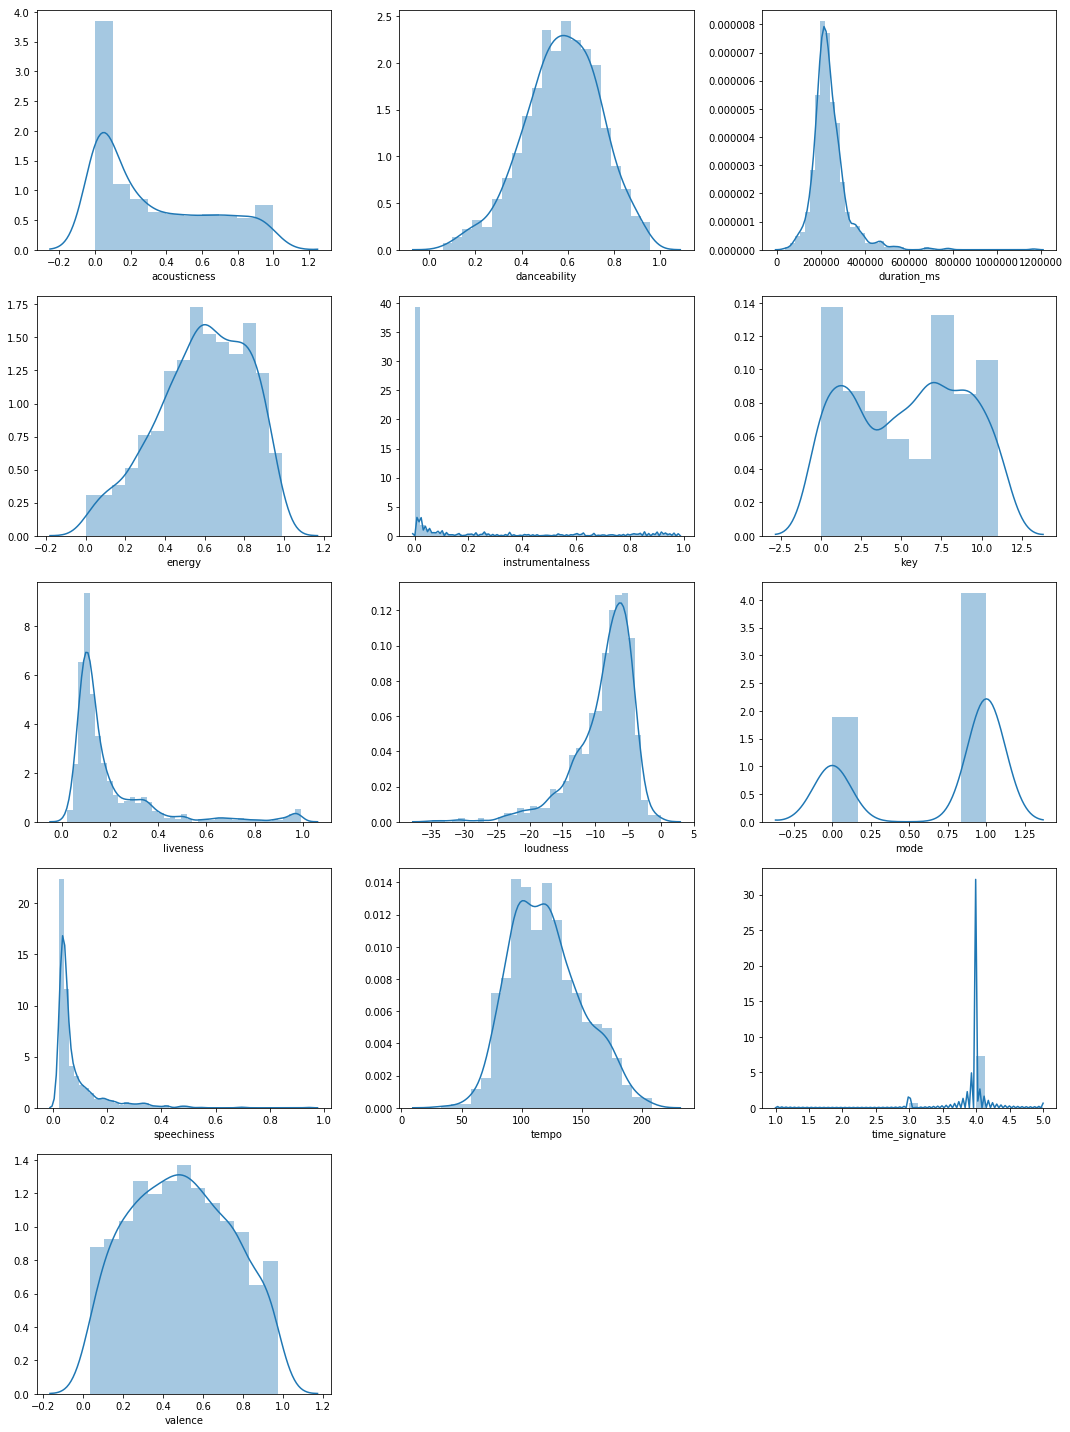

In [3]:
# *******************// Distribution of individual variables //******************

# Pull out predictor variables from df 
predictors = df.loc[:, ~df.columns.isin(['target'])]

# Create distribution plots
plt.figure(figsize=(15,20))

i = 1
for column in predictors.columns:
    plt.subplot(5, 3, i)
    sns.distplot(predictors[column])
    i+=1

plt.tight_layout()
plt.show()

Key Takeaways:
* A large chunk of the data has very low acousticness values
* Danceability and energy both tend to be moderate to moderate/high
* 3 dominant keys present
* Low liveness and speechiness central tendencies 
* Time signature predominately at 4.0

Now let's take a look at how the audio features vary by preference group.  Boxplots will be perfect for this.  Let's also use a t-test to compare means between preference groups.  Remember, songs I like have a target value of 1.

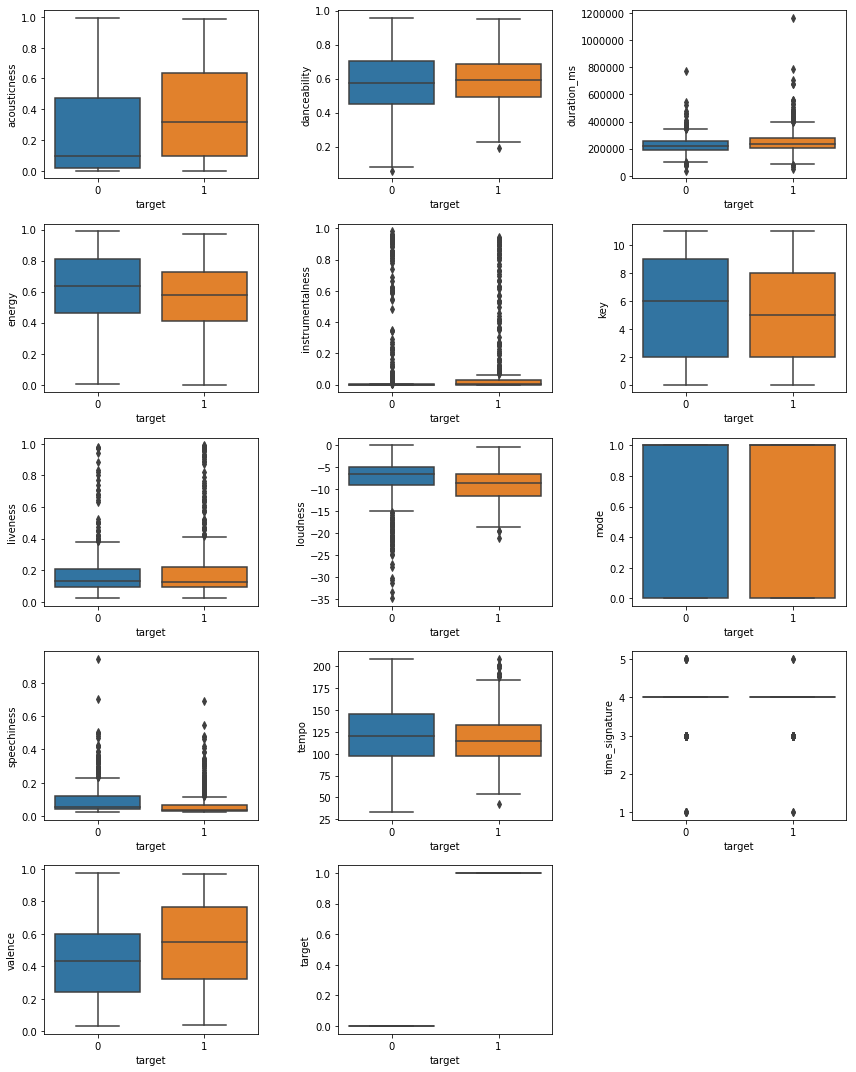

acousticness
Ttest_indResult(statistic=-5.530945108029791, pvalue=4.032238651895996e-08) 

danceability
Ttest_indResult(statistic=-1.6014009733335706, pvalue=0.1095929906952057) 

duration_ms
Ttest_indResult(statistic=-4.580172525509545, pvalue=5.210229717147444e-06) 

energy
Ttest_indResult(statistic=2.892030046160962, pvalue=0.003907645077729414) 

instrumentalness
Ttest_indResult(statistic=-0.2164295035750943, pvalue=0.8286955787604668) 

key
Ttest_indResult(statistic=2.131142436502913, pvalue=0.033312317285490965) 

liveness
Ttest_indResult(statistic=-2.367587521083302, pvalue=0.018087399532815556) 

loudness
Ttest_indResult(statistic=3.540347650554842, pvalue=0.00041735667409133827) 

mode
Ttest_indResult(statistic=-3.0369497095370215, pvalue=0.0024496511420562584) 

speechiness
Ttest_indResult(statistic=4.882953487953168, pvalue=1.2097485848523427e-06) 

tempo
Ttest_indResult(statistic=2.8114691027662513, pvalue=0.005024608799233538) 

time_signature
Ttest_indResult(statistic=-0.

In [4]:
# ***************// Variables by song preference //*****************

# Create boxplots based on song preference
plt.figure(figsize=(12,15))

i = 1
for column in df.columns:
    plt.subplot(5, 3, i)
    sns.boxplot(x=df['target'], y=df[column], orient='v')
    i+=1

plt.tight_layout()
plt.show()

# Test for significance between groups
for col in df.loc[:, 'acousticness':'valence'].columns:
    print(col)
    print(stats.ttest_ind(
        df[df['target'] == 0][col],
        df[df['target'] == 1][col]), '\n'
    )

Well that's pretty neat!  There are statistically significant differences between the preference groups in all audio features except danceability and time signature. 

__CORRELATIONS__

We've spent a lot of time looking at distributions of the individual audio features and their relationship to song preference.  What about correlation between the audio features themselves?  Strong correlations between variables can throw off our models so it's important to see what we're dealing with.

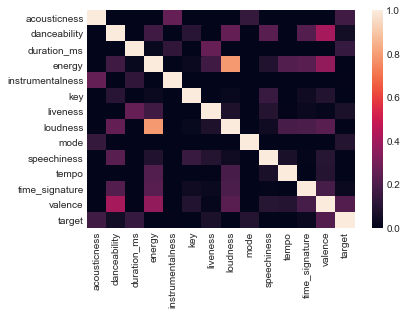

In [203]:
# **********************// Correlations //****************************

# Get correlation matrix, set vmin=0.0 to only include positively correlated variables
corr_matrix = df.corr()
sns.heatmap(corr_matrix, vmin=0.0)
plt.show()

In general, there isn't much correlation between variables.  This isn't all too surprising.  It seems quite likely that Spotify has put a lot of effort into feature engineering for use in their own recommender algorithms.  The only notable exception is the correlation between loudness and energy.  We'll address that next.

## Part 2: Feature Engineering

Now that we have a good feel for the data, the next step is feature selection and engineering.  The data is already in pretty good shape, so only a small amount of feature engineering is needed.  In this section, let's do the following:
* Create dummy variables for key
* Create interaction variable for loudness + energy
* Check correlations in feature dataset 
* Normalize the data
* Specify data for input into models 
  

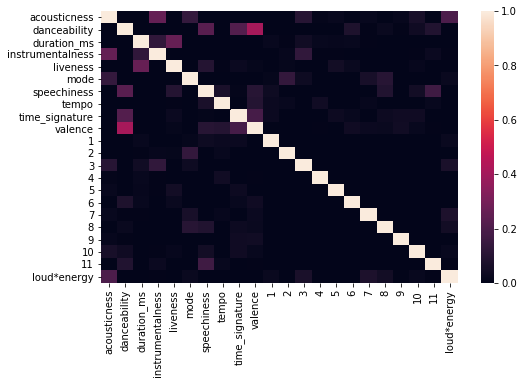

In [6]:
#*******************// Feature Engineering //****************************

# Create dummy variables for key, drop one
key_dummies = pd.get_dummies(data=df['key'])
key_dummies = key_dummies.drop(columns=[0])

# Join back with original df, store as new features df
features = df.join(key_dummies)

# Drop original key column from 
features = features.drop(columns=['key'])

# Create loudness/enery interaction
features['loud*energy'] = features['loudness'] * features['energy']

# Drop original loudness and energy columns, along with target
features = features.drop(columns=['loudness', 'energy', 'target'])

# Check feature correlations
corr_matrix = features.corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr_matrix, vmin=0.0)

plt.show()

In [7]:
# Normalize
from sklearn.preprocessing import normalize
normed_features = normalize(features)

# Specify model inputs to feed into pipelines
X = normed_features
y = df['target']

# Verify shapes align
print(X.shape)
print(y.shape)

(1038, 22)
(1038,)


## Part 3: Model Pipelines

Our data is ready to go.  Let's plug it into some models and see what predictive and explanatory power we can get.  In this section, I'd like to compare the performance of several different types of algorithms.

Here's what we'll explore:
1. Naive Bayes 
2. Logistic Regression 
    * LASSO/Ridge Regularization 
3. Decision Tree 
4. Random Forest
    * Gradient Boosted 
4. k-Nearest Neighbor

__CROSS-VALIDATION__

The first step is to split the data into a training and validation set.  Models will be optimized using the training set and the validation set will be used to test the model. This will come be useful for determining if a model is overfit.  For the training dataset, we'll randomly choose 70% of the data.  The remaining 30% will be used for validation.  We'll also use stratified sampling to maintain class balance when splitting the data.

In [169]:
# Import train/test/split
from sklearn.model_selection import train_test_split

# Split data, set test size to 30%, use stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    stratify=y,
    test_size=0.3, 
    random_state=17
)

# Examine shape of data sets
print('Training size:', X_train.shape, y_train.shape)
print('Test size:', X_test.shape, y_test.shape)

# Verify class balance in train/test sets
print(y_train.value_counts())
print(y_test.value_counts())

Training size: (726, 22) (726,)
Test size: (312, 22) (312,)
1    364
0    362
Name: target, dtype: int64
1    157
0    155
Name: target, dtype: int64


In [170]:
# Import some other performance metrics we'll use later on
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

__NAIVE BAYES__

The first algorithm we'll look at is Naive Bayes, a probabilistic classifier.  An important assumption of Naive Bayes is independence between the predictor variables.  Oftentimes, this is an invalid assumption.  However, in our case, the feature set has very little correlation so this model may work quite well.  Let's take a look.

In [171]:
# ********************// Naive Bayes //***************************

# Import model
from sklearn.naive_bayes import BernoulliNB

# Create instance
bnb = BernoulliNB()

# Fit training data
bnb.fit(X_train, y_train)

# Predict with training set
y_pred_train = bnb.predict(X_train)

# Predict with test set
y_pred_test = bnb.predict(X_test)

# Get accuracy scores
print('NB training accuracy score:', round(accuracy_score(y_pred_train, y_train), 3))
print('NB test accuracy score:', round(accuracy_score(y_pred_test, y_test), 3))

NB training accuracy score: 0.643
NB test accuracy score: 0.619


The model performs decently.  The training set accuracy is 64.3% and the test set accuracy is 61.9%.  This indicates the model is slightly overfit, but overall it's not too bad.

** Let's go on a brief tangent.  For this application, we're focusing in on overall model accuracy.  That's because my objective is pretty simple...either I'll like a song or I won't.  There's no increased risk to a false negative like there could be in other applications.

But if we really wanted to, we could pay attention to false positives,  false negatives, and/or measure the precision and recall of our model.  For kicks, let's take a brief look at what that sort of analysis would look like.  

In [181]:
# Confusion matrix training data
print('Confusion matrix training data: \n', confusion_matrix(y_train, y_pred_train), '\n')

# Classification metrics
print('Precision/Recall training data: \n', classification_report(y_train, y_pred_train))

Confusion matrix training data: 
 [[204 158]
 [101 263]] 

Precision/Recall training data: 
              precision    recall  f1-score   support

          0       0.67      0.56      0.61       362
          1       0.62      0.72      0.67       364

avg / total       0.65      0.64      0.64       726



From left to right, top to bottom, the confusion matrix gives the breakdown of true negatives (TN), false positives (FP), false negatives (FN), and true positives (TP).  

The classification report gives us precision, recall, and f1-scores.  

__Precision__ is a measurement of the true positives relative to the total number of predicted positive values (263/421), or conversely, the number of true negatives relative to the total number of predicted negative values (204/305).

__Recall__ (or sensitivity) is a measurement of the true positives relative to the total number of actual positive values (263/364), or conversely, the number of true negatives relative to the total number of actual negative values (204/362).  

The __F1 score__ combines precision and recall, providing the harmonic mean.  


Ok, enough of that.  Let's get back to the models and evaluating their overall accuracy.

__LOGISTIC REGRESSION__

The next algorithm we'll look at is logistic regression.  

Logistic regression training accuracy score:  0.678
Logistic regression test accuracy score:  0.679


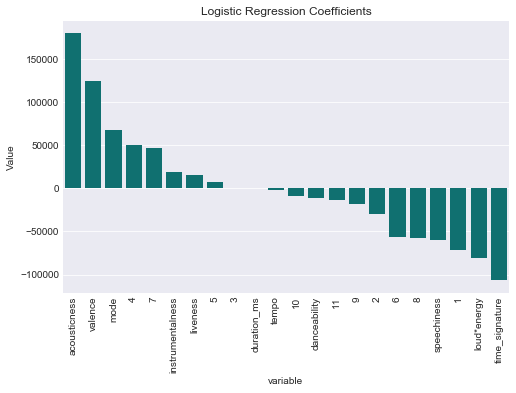

In [173]:
#**********************// Logistic Regression //*****************************

# Import model
from sklearn.linear_model import LogisticRegression

# Create instance.  Set C very large so there's no regularization 
lr = LogisticRegression(C=1e10)

# Fit with training data
lr.fit(X_train, y_train)

# Get accuracy score and confusion matrix
print('Logistic regression training accuracy score: ', round(lr.score(X_train, y_train), 3))
print('Logistic regression test accuracy score: ', round(lr.score(X_test, y_test), 3))

# Get coefficients, flatten, and send to list
coef_list = lr.coef_.ravel().tolist()

# Create new data frame with coefficients
coef = pd.DataFrame(data=coef_list, columns=['coef'])

# Add in variable names
coef['variable'] = list(features)

# Sort by coefficient value
sorted_coef = coef.sort_values('coef', ascending=False)

# Plot 
plt.figure(figsize=(8,5))
sns.set_style('darkgrid')
sns.barplot(x=sorted_coef['variable'], y=sorted_coef['coef'], color='teal')
plt.xticks(rotation=90)
plt.ylabel('Value')
plt.title('Logistic Regression Coefficients')

plt.show()

Logistic regression performed better than Naive Bayes and was not overfit.  Here's what we learned:
* Training accuracy was 54.1% 
* Test accuracy was 54.8%  
* Acousticness and valence had the strongest positive correlations 
* Time_signature and the loud+energy interaction had the strongest negative correlations

__Regularization Using GridSearchCV__

Now let's look at regularizaton methods to see if we can improve the performance of our logistic regression.  We'll automate the hyperparameter selection process by using grid search to select the best regularization method and coefficient.  

Note:<br>
'L1' = LASSO Regression<br>
'L2' = Ridge Regression


In [183]:
# ************************** Logistic Regression - Grid Search ****************************

# Import Grid Search with cross validation
from sklearn.model_selection import GridSearchCV

# Create a new instance for regularization
lr_reg = LogisticRegression()

# Specify regularization penalties
penalty = ['l1', 'l2']

# Specify regularization hyperparameter range
C = np.logspace(3, 11, 5)

# Set hyperparameters 
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(lr_reg, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X_train, y_train)

# Get results
print('Best Penality:', results.best_estimator_.get_params()['penalty'])
print('Best C:', results.best_estimator_.get_params()['C'])
print('Best score:', round(results.best_score_, 3))

Best Penality: l2
Best C: 100000000000.0
Best score: 0.7


Ridge Regression training accuracy:  0.713
Ridge Regression test accuracy:  0.66


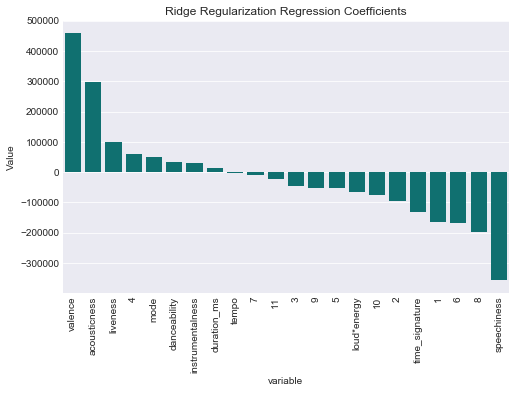

In [184]:
# ***************************** Ridge Regularization ************************

# Train Ridge Model (L2) using hyperparameters from grid search

# Get hyperparameters from above
C = results.best_estimator_.get_params()['C']
penalty = results.best_estimator_.get_params()['penalty']

# Create a new instance of regularized model
lr_reg = LogisticRegression(C=C, penalty=penalty)

# Fit with training data
lr_reg.fit(X_train, y_train)

# Get accuracy scores
print('Ridge Regression training accuracy: ', round(lr_reg.score(X_train, y_train), 3))
print('Ridge Regression test accuracy: ', round(lr_reg.score(X_test, y_test), 3))

# Flatten coefficients and send to list
l2_coef = lr_reg.coef_.ravel().tolist()

# Create new data frame with coefficients
l2_coef = pd.DataFrame(data=l1_coef, columns=['coef'])

# Add in variable names
l2_coef['variable'] = list(features)

# Sort by coefficient value
sorted_coef = l2_coef.sort_values('coef', ascending=False)

# Plot 
plt.figure(figsize=(8,5))
sns.set_style('darkgrid')
sns.barplot(x=sorted_coef['variable'], y=sorted_coef['coef'], color='teal')
plt.xticks(rotation=90)
plt.ylabel('Value')
plt.title('Ridge Regularization Regression Coefficients')
plt.show()

Here's what we learned using the grid search for regularization:
* Ridge regularization selected with very large C value
* Training accuracy: 71.3%
* Test accuracy: 66.0%  
* Slightly overfit and slightly less performant than standard logistic regression
* Valence and acousticness remain features with the strongest positive correlation
* Speechiness the feature with the strongest negative correlation 

__DECISION TREE__

Now let's try out a decision tree.  We'll again use a grid search for hyperparameter selection.

In [176]:
# **************** // Decision Tree - Grid Search //***************

# Import model
from sklearn import tree

# Create instance, set criterion to entropy
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=17
)

# Specify hyperparameter range
max_depth = np.arange(3, 10, 1)
max_features = np.arange(5, 22, 1)

# Set hyperparameters 
hyperparameters = dict(
    max_depth=max_depth, 
    max_features=max_features
)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(decision_tree, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X_train, y_train)

# Get results
print('Max Depth:', results.best_estimator_.get_params()['max_depth'])
print('Max Features:', results.best_estimator_.get_params()['max_features'])
print('Best score:', round(results.best_score_, 3))

Max Depth: 8
Max Features: 15
Best score: 0.646


Decision tree training accuracy:  0.826
Decision tree test accuracy:  0.612


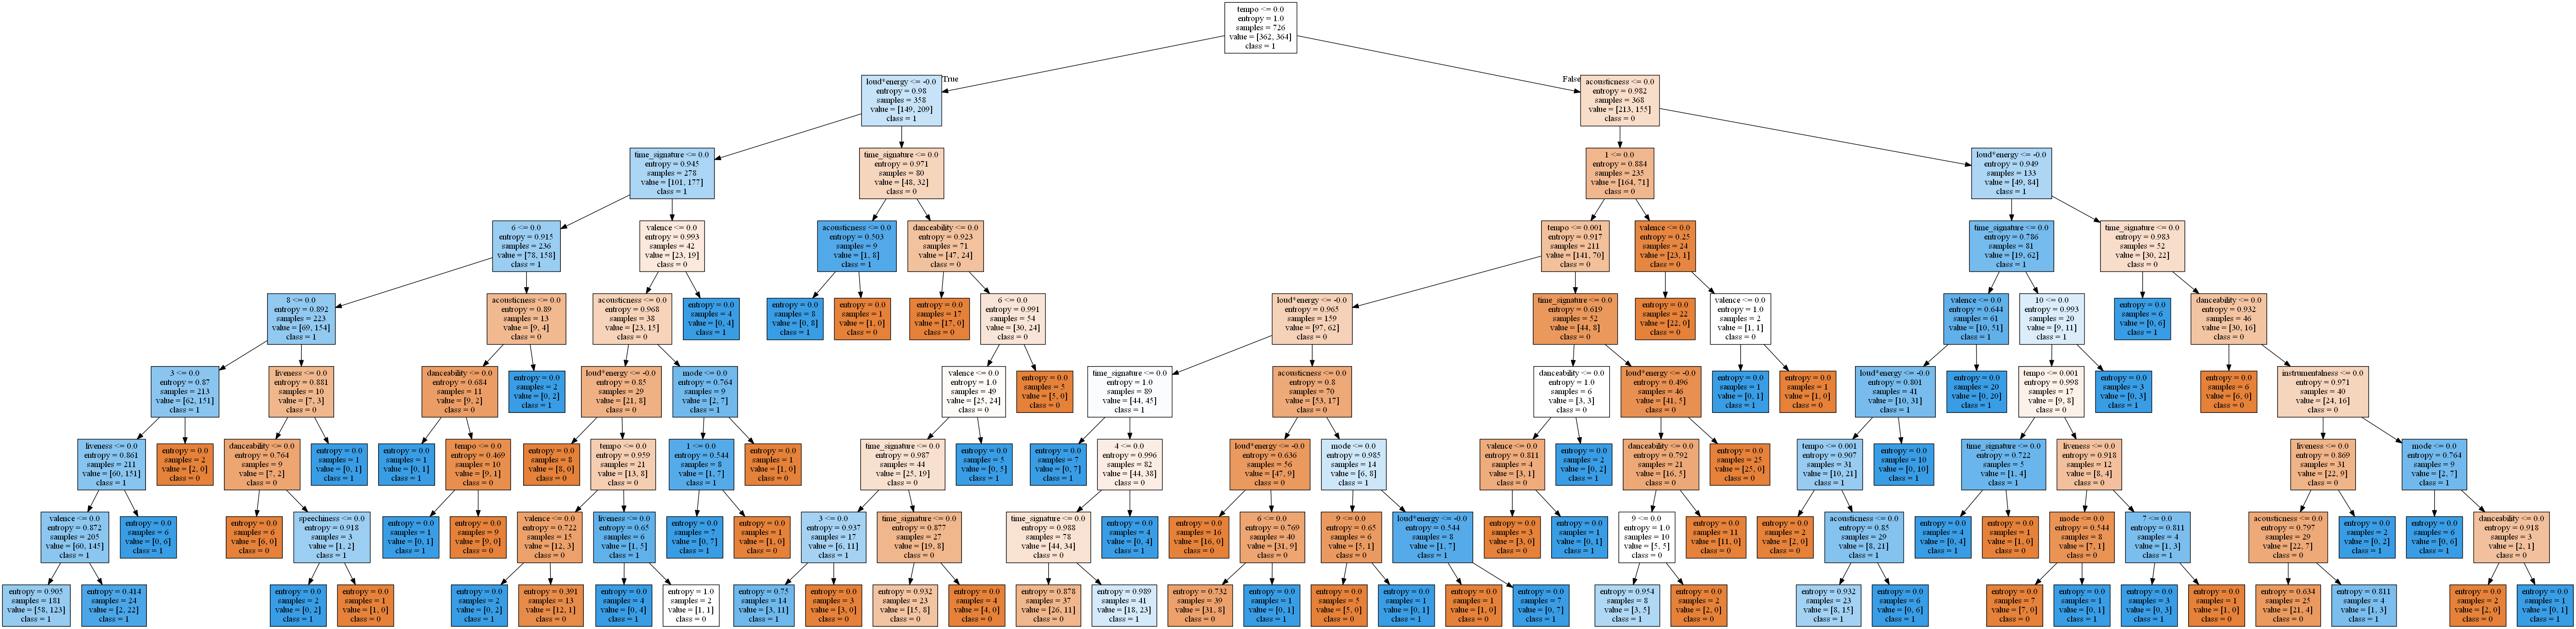

In [185]:
# ********************// Decision Tree - Model & Visualization //*******************

# Build model with grid search results

# Import relevant libraries
from IPython.display import Image
from sklearn import tree

# Import package for rendering tree
import pydotplus
from pydotplus import graphviz

# Create model
best_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=17,
    max_depth=8,
    max_features=15
)

# Fit with test data
best_tree.fit(X_train, y_train)

# Get accuracy scores
print('Decision tree training accuracy: ', round(best_tree.score(X_train, y_train), 3))
print('Decision tree test accuracy: ', round(best_tree.score(X_test, y_test), 3))

# Create tree graphic
dot_data = tree.export_graphviz(
    best_tree, out_file=None,
    feature_names=features.columns,
    class_names=['0', '1'],
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

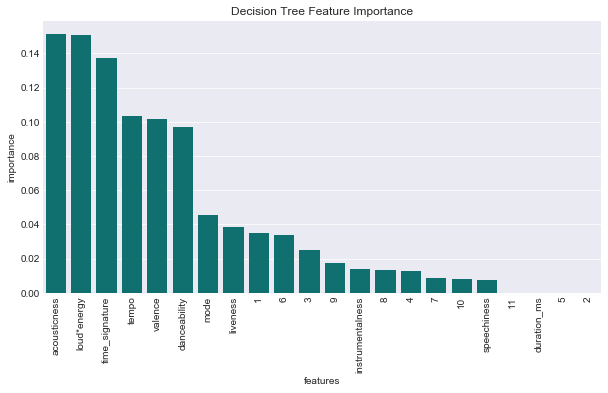

In [186]:
# Feature importance

# Create new df to store features
best_tree_features = pd.DataFrame()
best_tree_features['importance'] = best_tree.feature_importances_
best_tree_features['features'] = features.columns

# Sort descending
sorted_tree = best_tree_features.sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.set_style('darkgrid')
sns.barplot(x=sorted_tree['features'] , y=sorted_tree['importance'], color='teal')
plt.title('Decision Tree Feature Importance')
plt.xticks(rotation=90)
plt.show()

The Decision Tree is the worst performing model so far and is also very overfit (as expected).  Here's what we learned:
* Training accuracy: 82.6%
* Test accuracy: 61.2%
* Time_signature, loud+energy interaction, and acousticness most important features

__RANDOM FOREST__

Let's try out Random Forest and Gradient Boosted Random Forest algorithms next.  Random Forests work by generating several different trees from subsets of the data and then averaging the results.  This can improve overall accuracy and combat overfitting seen in a single Decision Tree. Gradient Boosted Random Forests are optimized to reduce residuals of each successive tree in the forest.  We'll again use a grid search to select the best hyperparameters for each model variation.

__Random Forest__


In [180]:
# ************************ // Random Forest - Grid Search //*****************

from sklearn import ensemble

# Create instance.  Set # features to sqrt of total.
forest = ensemble.RandomForestClassifier(
    random_state=17,
    max_features='sqrt'
)

# Specify hyperparameter range
criterion = ['entropy', 'gini']
n_estimators = np.arange(200, 300, 10)
max_depth = np.arange(8, 15, 1)

# Set hyperparameters 
hyperparameters = dict(
    criterion=criterion,
    n_estimators=n_estimators, 
    max_depth=max_depth
)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(forest, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X_train, y_train)

# Get results
print('Criterion:', results.best_estimator_.get_params()['criterion'])
print('n estimators:', results.best_estimator_.get_params()['n_estimators'])
print('Max depth:', results.best_estimator_.get_params()['max_depth'])
print('Best score:', round(results.best_score_, 3))

Criterion: entropy
n estimators: 250
Max depth: 14
Best score: 0.705


In [188]:
# ******************** // Random Forest - Model //******************

# Build model
forest = ensemble.RandomForestClassifier(
    criterion='entropy',
    random_state=17,
    max_features='sqrt',
    max_depth=14,
    n_estimators=250
)

# Fit with training data
forest.fit(X_train, y_train)

# Get accuracy scores
print('Forest training score: ', round(forest.score(X_train, y_train), 3))
print('Forest test score: ', round(forest.score(X_test, y_test), 3))

Forest training score:  0.983
Forest test score:  0.654


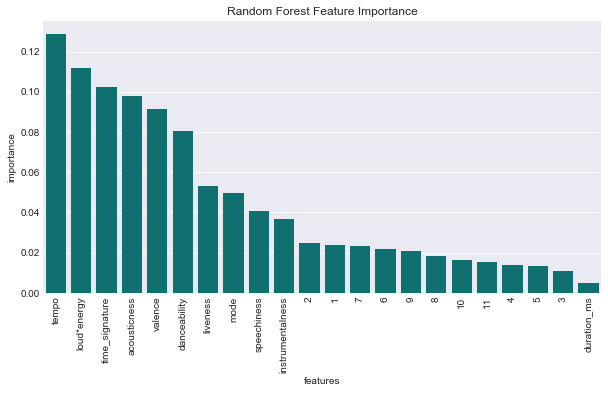

In [189]:
# Evaluate feature importance
forest_features = pd.DataFrame()
forest_features['importance'] = forest.feature_importances_
forest_features['features'] = features.columns
sorted_forest = forest_features.sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.set_style('darkgrid')
sns.barplot(x=sorted_forest['features'] , y=sorted_forest['importance'], color='teal')
plt.title('Random Forest Feature Importance')
plt.xticks(rotation=90)
plt.show()

__Gradient Boosted Forest__

In [192]:
# *********************// Gradient Boosted Forest - Grid Search //******************

# Create instance
gbc = ensemble.GradientBoostingClassifier(
    random_state=17
)

# Specify hyperparameter range
loss = ['deviance', 'exponential']
n_estimators = np.arange(100, 130, 5)
max_depth = np.arange(2, 5, 1)

# Set hyperparameters 
hyperparameters = dict(
    n_estimators=n_estimators, 
    max_depth=max_depth, 
    loss=loss, 
)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(gbc, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X_train, y_train)

# Get results
print('n estimators:', results.best_estimator_.get_params()['n_estimators'])
print('Max depth:', results.best_estimator_.get_params()['max_depth'])
print('Loss function: ', results.best_estimator_.get_params()['loss'])
print('Best score:', round(results.best_score_, 3))

n estimators: 105
Max depth: 4
Loss function:  exponential
Best score: 0.667


In [195]:
# ******************** // Gradient Boosted Forest - Model //******************

# Build model
gbc = ensemble.GradientBoostingClassifier(
    loss='deviance',
    n_estimators=105,
    random_state=17,
    max_depth=4, 
)

# Fit with training data
gbc.fit(X_train, y_train)

# Get accuracy scores
print('Boosted Forest training score: ', round(gbc.score(X_train, y_train), 3))
print('Boosted Forest test score: ', round(gbc.score(X_test, y_test), 3))

Boosted Forest training score:  0.921
Boosted Forest test score:  0.657


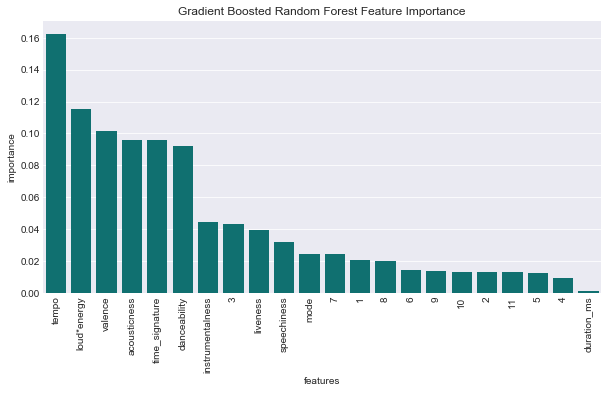

In [196]:
# Evaluate feature importance
gbc_features = pd.DataFrame()
gbc_features['importance'] = gbc.feature_importances_
gbc_features['features'] = features.columns
gbc_sorted = gbc_features.sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.set_style('darkgrid')
sns.barplot(x=gbc_sorted['features'] , y=gbc_sorted['importance'], color='teal')
plt.title('Gradient Boosted Random Forest Feature Importance')
plt.xticks(rotation=90)
plt.show()

Suprisingly, both the Random Forest and Gradient Boosted Random Forests are very overfit.  This is an unexpected response, particularly since we used stratified sampling and a grid search to select hyperparameters.  Despite the overfitting, both models performed similarly to the other models with accuracies near 65%.  

Here's a summary of what we learned:
* Random Forest
    * Training accuracy: 98.3%
    * Test accuracy: 65.4%
* Gradient Boosted Forest
    * Training accuracy: 92.1%
    * Test accuracy: 65.7%
* Overfit; Gradient Boosted less so than Random Forest.  
* Computationally expensive, particularly with increasing number of parameters in grid search.
* Tempo predominantly the most important feature followed by loud+energy interaction in both variations.

__4. K-NEAREST NEIGHBOR__ 

For our final model we'll try out is k nearest-neighbors, a model based on similarity.  We'll use grid search to select the optimal number of neighbors and determine whether or not distance weighting should be used.

In [197]:
# *********************// KNN - Grid Search //***********************

from sklearn.neighbors import KNeighborsClassifier

# Create instance
knn = KNeighborsClassifier()

# Specify hyperparameter range
n_neighbors = np.arange(1, 100, 1)
weights = ['uniform', 'distance']

# Set hyperparameters 
hyperparameters = dict(
    n_neighbors=n_neighbors, 
    weights=weights
)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(knn, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X_train, y_train)

# Get results
print('n neighbors:', results.best_estimator_.get_params()['n_neighbors'])
print('Weight:', results.best_estimator_.get_params()['weights'])
print('Best score:', round(results.best_score_, 3))

n neighbors: 3
Weight: distance
Best score: 0.621


In [198]:
# *********************// KNN - Model //***********************

# Build model
knn = KNeighborsClassifier(
    n_neighbors=3,
    weights='distance'
)

# Fit 
knn.fit(X_train, y_train)

# Get scores
print('KNN train score: ', round(knn.score(X_train, y_train), 3))
print('KNN test score: ', round(knn.score(X_test, y_test), 3))

KNN train score:  1.0
KNN test score:  0.606


The grid search indicates distance weighting using the 3 nearest neighbors performs the best.  However, this model is very overfit.  Let's use the same number of neighors but with uniform weighting to see if we can reduce overfitting.

In [199]:
knn = KNeighborsClassifier(
    n_neighbors=3,
    weights='uniform'
)

knn.fit(X_train, y_train)

# Get scores
print('Weighted KNN train score: ', round(knn.score(X_train, y_train), 3))
print('Weighted KNN test score: ', round(knn.score(X_test, y_test), 3))

Weighted KNN train score:  0.804
Weighted KNN test score:  0.603


The unweighted model performs similar to the weighted model on test data.  It is less overfit than the weighted model, however both variations are still very overfit.  To recap:
* Grid search hyperparameter selection: n=3, weighting=distance
* Weighted:
    * Test accuracy: 100%
    * Training accuracy: 60.6%
* Unweighted (uniform):
    * Test accuracy: 80.4%
    * Training accuracy: 60.3%

## Conclusions

Over the series of three notebooks, we've built a classifier to predict whether or not I will like a song based on Spotify's audio features.  A secondary objective was to understand why I like the music that I do.  Using data from my own Spotify account, several types of models were tested (shown with % accuracy on test data):
* Naive Bayes (61.9%)
* Logistic Regression (66.0 - 67.9%)
* Decision Tree (61.2%)
* Random Forests (65.4% - 65.7%)
* k-Nearest Neighbor (60.3 - 60.6%)

Overall, model accuracy ranged from ~60-68%.  The best performing model was logistic regression.  Given I have a varied taste in music, it's not suprising model performance was what it was.  I like many different types of music based on my mood and my playlist of 'liked' data is quite diverse.  Plus, looking at the boxplots of audio features reveals quite a bit of overlap in many of the features regardless of preference class.  This indicates there may be more to my music preferences than audio features alone.  I know for a fact that I shy away from anything top 40, regardless of how catchy they may be.  That being said, all models were able to predict song preference better than a random guess.

And perhaps more interesting than predicting song preference, I got to peek under the hood and better understand the mechanics of my musicial tastes.  I learned that I tend to like songs with acoustic tendencies and higher valence.  I also prefer songs with a slower tempo, lower energy, and lower loudness.  These characteristics make sense given what I know about the current songs in my Spotify playlist.  It'll be interesting to add to my playlist over time and see how things change.  Sometimes I really am in the mood for fast, high energy songs.

Thanks for reading!